Clean the smiles from Colin et al's csv files from v1.0.1: https://zenodo.org/record/3715478#.YFfpgh0pDUI

In [1]:
import copy
import pandas as pd

from rmgpy.molecule.molecule import *
from rmgpy.species import Species
from rdkit import Chem
from rdkit.Chem.rdchem import ChiralType
from rdkit.Chem import AllChem
from rdkit.Chem.rdchem import AtomValenceException
from rdkit.Geometry import Point3D
from rdkit.six import StringIO
from typing import List, Tuple, Union

from arc.species import ARCSpecies
from arc.reaction import ARCReaction

from arc.species.converter import (check_isomorphism,
                                   molecules_from_xyz,
                                   str_to_xyz,
                                   xyz_to_str,
                                   xyz_to_x_y_z,
                                   xyz_to_xyz_file_format,
                                   xyz_to_dmat,
                                   xyz_to_coords_list,
                                  )
from arc.parser import parse_xyz_from_file
from IPython.display import display
import arc
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

### Define helper functions

In [2]:
def look_for_adjacent_charges(smiles, idx):
    # create mol from original smiles
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    out = AllChem.EmbedMolecule(mol, maxAttempts=5000)
    # set label on H atoms
    [a.SetAtomMapNum(a.GetIdx()+1) for a in mol.GetAtoms()]
    
    index_str = f'{idx:06}'  # convert to formatted string
    if out != 0:
        print(f'ERROR: Could not embed reactant for rxn {index_str}: {smiles} !!!!!!!\n')
        failed_embedding_idx.append(index_str)
    
    for i, b in enumerate(mol.GetBonds()):
        ac1 = b.GetBeginAtom().GetFormalCharge()
        ac2 = b.GetEndAtom().GetFormalCharge()
        
        # skip triple bonds as these are often carbenes, whose resonance structure is better represented as N+ and C-
        if b.GetBondType() == Chem.BondType.TRIPLE:
            continue
        
        # detects radical electrons or formal charges on neighboring atoms    
        if (abs(ac1) + abs(ac2) == 2) and (ac1 + ac2 == 0) :
            
            b.GetBeginAtom().SetFormalCharge(0)
            b.GetEndAtom().SetFormalCharge(0)
            new_mol = Chem.EditableMol(mol)  # an editable molecule class
            # RW molecule class (read/write)
            # This class is a more-performant version of the EditableMolecule class in that it is a ‘live’ molecule and shares the interface from the Mol class. 
            # All changes are performed without the need to create a copy of the molecule using GetMol()
            # new_mol = Chem.RWMol(mol) 
            
            a1 = b.GetBeginAtomIdx()
            a2 = b.GetEndAtomIdx()
            new_mol.RemoveBond(a1, a2)
            new_mol.AddBond(a1, a2, Chem.BondType.DOUBLE)

            new_mol = new_mol.GetMol()
            # set label on H atoms
            # print([a.SetAtomMapNum(a.GetIdx()+1) for a in new_mol.GetAtoms()])
            # [a.SetAtomMapNum(a.GetIdx()+1) for a in new_mol.GetAtoms()]
            new_smi = Chem.MolToSmiles(new_mol)
            
            # use try except to catch valence errors, such as assigning 5 bonds to N
            try:
                new_mol.UpdatePropertyCache()
            except Exception as e:
                continue
                
            print(f'rxn {index_str} with smiles {smiles} had neighboring formal charges')
            display(mol)
            
            print(f'Propose adding a double bond instead as {new_smi}')
            display(new_mol)
            print('*'*90)
            
            return idx

There is a lot of overlap between the wb97xd3 and b97d3 reactions. Paste all of the cleaned smiles from wb97xd3 into the `b97d3_cleaned.csv`. The clean any remaining smiles

In [3]:
b97d3 = 'b97d3_cleaned.csv'
df_colin = pd.read_csv(b97d3)
df_colin

,idx,rsmi,psmi,ea,dh
0,0,[C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8...,[C:1]1([H:7])([H:8])/[C:2](=[N:3]\[H:9])[N:6]1...,77.689287,45.532073
1,1,[C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8...,[C:1]([C:2](=[N:3][O-:4])[N+:6]#[N:5])([H:7])(...,45.367710,19.774235
2,2,[C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8...,[C:1](=[C:2]1[N-:3][O+:4]=[N:5][N:6]1[H:9])([H...,84.713035,54.584197
3,3,[C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8...,[C:1]([C:2]#[N:3])([H:7])([H:8])[H:9].[O:4]=[N...,24.035982,-15.011997
4,4,[C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8...,[C:1](=[C:2]1[N:3]([H:8])[O:4][N:5]=[N:6]1)([H...,77.679891,34.331205
...,...,...,...,...,...
16360,16360,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,[C-:6]#[O+:7].[C:1]([C:2]([O:3][H:12])([H:11])...,81.109624,26.321959
16361,16361,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,[C:1](=[C:2]([C:4]([O:5][C:6](=[O:7])[H:15])([...,60.177990,16.450943
16362,16362,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,[C:1]([C:2](=[O:3])[C:4]([O:5][C:6](=[O:7])[H:...,77.095485,6.748584
16363,16363,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,[C:1]([C:2](=[O:3])[C:4]([H:11])([H:13])[H:14]...,50.491283,-18.449602


In [4]:
df_colin.psmi.unique().shape

(16271,)

In [5]:
df_colin_unique = df_colin.drop_duplicates(subset=['psmi'])
df_colin_unique

,idx,rsmi,psmi,ea,dh
0,0,[C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8...,[C:1]1([H:7])([H:8])/[C:2](=[N:3]\[H:9])[N:6]1...,77.689287,45.532073
1,1,[C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8...,[C:1]([C:2](=[N:3][O-:4])[N+:6]#[N:5])([H:7])(...,45.367710,19.774235
2,2,[C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8...,[C:1](=[C:2]1[N-:3][O+:4]=[N:5][N:6]1[H:9])([H...,84.713035,54.584197
3,3,[C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8...,[C:1]([C:2]#[N:3])([H:7])([H:8])[H:9].[O:4]=[N...,24.035982,-15.011997
4,4,[C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8...,[C:1](=[C:2]1[N:3]([H:8])[O:4][N:5]=[N:6]1)([H...,77.679891,34.331205
...,...,...,...,...,...
16359,16359,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,[C:1]([C:4]([C:2](=[O:3])[H:11])([H:13])[H:14]...,43.791585,-9.724626
16360,16360,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,[C-:6]#[O+:7].[C:1]([C:2]([O:3][H:12])([H:11])...,81.109624,26.321959
16361,16361,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,[C:1](=[C:2]([C:4]([O:5][C:6](=[O:7])[H:15])([...,60.177990,16.450943
16362,16362,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,[C:1]([C:2](=[O:3])[C:4]([O:5][C:6](=[O:7])[H:...,77.095485,6.748584


RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: getExplicitValence() called without call to calcExplicitValence()
RDKit ERROR: Violation occurred on line 196 in file /Users/glandrum/anaconda3/conda-bld/rdkit_1591931638269/work/Code/GraphMol/Atom.cpp
RDKit ERROR: Failed Expression: d_explicitValence > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [20:51:02] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: getExplicitValence() called without call to calcExplicitValence()
RDKit ERROR: Violation occurred on line 196 in file /Users/glandrum/anaconda3/conda-bld/rdkit_1591931638269/work/Code/GraphMol/Atom.cpp
RDKit ERROR: Failed Expression: d_explicitValence > -1
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [20:51:02] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: getExplicitValence() called without call to calcExplicitValence()
RDKit ERROR: Violation occurred on line 196 in file /Users/g

ERROR: Could not embed reactant for rxn 016137: [N:1](=[C-:2][C@@:3]1([H:8])[O:4][C@@:5]2([H:9])[C:6]([H:10])([H:11])[C+:7]12)[H:12] !!!!!!!

ERROR: Could not embed reactant for rxn 016139: [N-:1]=[C:2]([C@@:3]1([H:8])[O:4][C@@:5]2([H:9])[C:6]([H:10])([H:11])[C+:7]12)[H:12] !!!!!!!



RDKit ERROR: [20:51:55] Explicit valence for atom # 4 O, 4, is greater than permitted
RDKit ERROR: [20:51:55] Explicit valence for atom # 4 O, 3, is greater than permitted


ERROR: Could not embed reactant for rxn 016148: [N+:1]1#[C:2][C@@:3]2([H:8])[O:4][C-:5]([H:9])[C:6]([H:10])([H:11])[C@@:7]12[H:12] !!!!!!!



RDKit ERROR: [20:52:00] Explicit valence for atom # 3 O, 3, is greater than permitted


ERROR: Could not embed reactant for rxn 016155: [O:1]([C@@:2]1([H:9])[C:3]([H:10])([H:11])/[C:4](=[N:5]/[H:12])[C:7]#[C:6]1)[H:8] !!!!!!!

ERROR: Could not embed reactant for rxn 016166: [O:1]([C@:2]1([H:9])[N+:5]#[C:4][C:3]([H:10])([H:11])[C:6]1=[C-:7][H:12])[H:8] !!!!!!!

ERROR: Could not embed reactant for rxn 016198: [C:1]([C:2]1=[C:3]2[C:4]([H:11])([H:12])[C@@:5]2([C:7]([H:13])([H:14])[H:15])[O:6]1)([H:8])([H:9])[H:10] !!!!!!!

ERROR: Could not embed reactant for rxn 016202: [C:1]([C:2]1=[C:3]2[C:4]([H:11])([H:12])[C@:5]12[O:6][C:7]([H:13])([H:14])[H:15])([H:8])([H:9])[H:10] !!!!!!!



RDKit ERROR: [20:52:28] Explicit valence for atom # 1 N, 5, is greater than permitted
RDKit ERROR: [20:52:28] Explicit valence for atom # 1 N, 5, is greater than permitted
RDKit ERROR: [20:52:28] Explicit valence for atom # 4 N, 5, is greater than permitted
RDKit ERROR: [20:52:28] Explicit valence for atom # 2 N, 5, is greater than permitted
RDKit ERROR: [20:52:28] Explicit valence for atom # 2 N, 5, is greater than permitted
RDKit ERROR: [20:52:28] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [20:52:28] Explicit valence for atom # 3 N, 5, is greater than permitted
RDKit ERROR: [20:52:28] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [20:52:28] Explicit valence for atom # 2 N, 5, is greater than permitted
RDKit ERROR: [20:52:28] Explicit valence for atom # 2 N, 5, is greater than permitted
RDKit ERROR: [20:52:28] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [20:52:28] Explicit valence for atom # 5 

ERROR: Could not embed reactant for rxn 016311: [C:1]([C@@:2]1([H:11])[C@@:3]2([H:12])[C:4]([H:13])([H:14])[C:5]([H:15])([H:17])[C:6]([H:16])=[C:7]12)([H:8])([H:9])[H:10] !!!!!!!

rxn 016330 with smiles [N:1]([C:3](=[C:2]=[N:7][C+:5]([N-:4][H:11])[O:6][H:12])[H:10])([H:8])[H:9] had neighboring formal charges


RDKit ERROR: [20:52:41] Explicit valence for atom # 3 N, 5, is greater than permitted
RDKit ERROR: [20:52:41] Explicit valence for atom # 3 N, 4, is greater than permitted


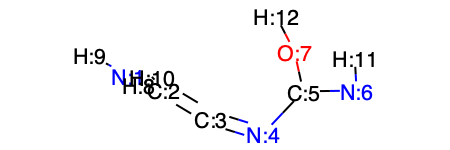

Propose adding a double bond instead as [N:1]([C:2](=[C:3]=[N:4][C:5](=[N:6][H:11])[O:7][H:12])[H:10])([H:8])[H:9]


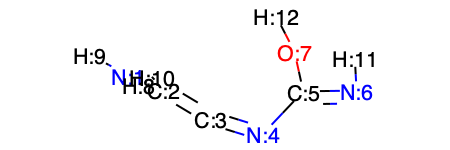

******************************************************************************************
rxn 016347 with smiles [N+:1]1([H:8])([H:9])[C+:2]([C-:3]([N+:4](=[C-:5][O:6][H:12])[H:11])[H:10])[N-:7]1 had neighboring formal charges


RDKit ERROR: [20:52:41] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [20:52:41] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [20:52:41] Explicit valence for atom # 2 N, 5, is greater than permitted
RDKit ERROR: [20:52:41] Explicit valence for atom # 3 N, 4, is greater than permitted


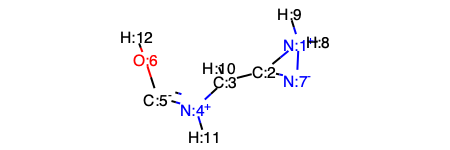

Propose adding a double bond instead as [N+:1]1([H:8])([H:9])[C:2](=[C:3]([N+:4](=[C-:5][O:6][H:12])[H:11])[H:10])[N-:7]1


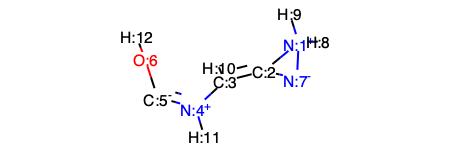

******************************************************************************************
rxn 016348 with smiles [N:1]([n+:7]1[c-:2][c:3]([H:10])[n:4]([H:11])[c:5]1[O:6][H:12])([H:8])[H:9] had neighboring formal charges


RDKit ERROR: [20:52:41] Can't kekulize mol.  Unkekulized atoms: 2 3 5
RDKit ERROR: 


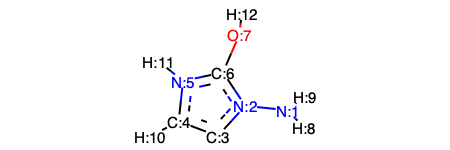

Propose adding a double bond instead as [N:1]([n:2]1[c:6]([O:7][H:12])[n:5]([H:11])[c:4]([H:10])[c:3]=1)([H:8])[H:9]


RDKit ERROR: [20:52:41] Can't kekulize mol.  Unkekulized atoms: 2 3 5
RDKit ERROR: 


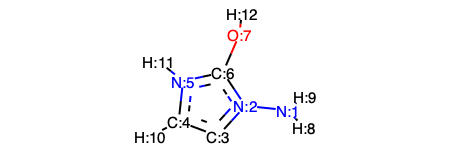

******************************************************************************************
rxn 016349 with smiles [N-:1]([C+:2]1[C-:3]([H:10])[N+:4]([H:9])([H:11])[C+:5]([O:6][H:12])[N-:7]1)[H:8] had neighboring formal charges


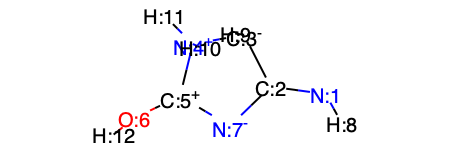

Propose adding a double bond instead as [N:1](=[C:2]1[C-:3]([H:9])[N+:4]([H:10])([H:11])[C+:5]([O:6][H:12])[N-:7]1)[H:8]


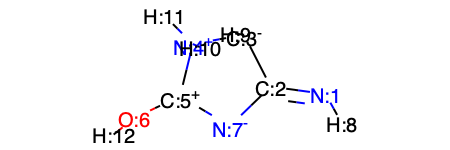

******************************************************************************************


RDKit ERROR: [20:52:41] Explicit valence for atom # 5 O, 4, is greater than permitted
RDKit ERROR: [20:52:41] Explicit valence for atom # 4 O, 3, is greater than permitted


In [105]:
# work in increments of 2000 reactions
# ignore molecules that cannot be kekulized
start = 16000
failed_embedding_idx = []
for i, psmi in enumerate(df_colin_unique.psmi.values[start:]): # start+2000   start:
    i += start
    
    # only look at reactions with 1 product
    num_products = len(psmi.split('.'))
    if num_products == 1:
        idx = df_colin_unique.idx.values[i]
        look_for_adjacent_charges(psmi, idx)

Verify that RDKit preserved the atom mapping in the new SMILES


[N:1]([C+:2]([N-:3][C:4](=[N+:5]=[N-:6])[H:9])[H:10])([H:7])[H:8]


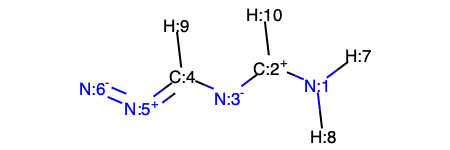

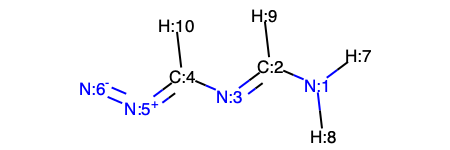

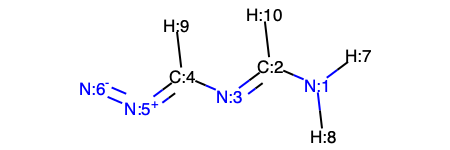

In [9]:
#rxn000466
smiles = df_colin.psmi.values[466]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# H atom map is out of order in smiles!
smiles = '[N:1]([C:2](=[N:3][C:4](=[N+:5]=[N-:6])[H:10])[H:9])([H:7])[H:8]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

# cleaned. 
smiles = '[N:1]([C:2](=[N:3][C:4](=[N+:5]=[N-:6])[H:9])[H:10])([H:7])[H:8]'
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol3)

[N:1]([C+:2]([N-:3][H:9])[N:6]([N+:5]#[C-:4])[H:10])([H:7])[H:8]


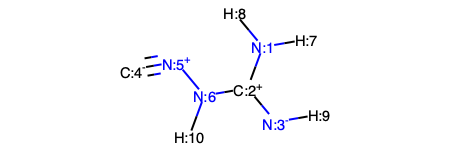

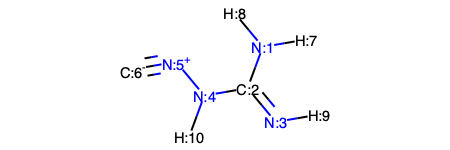

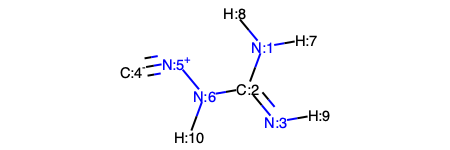

In [14]:
# rxn000471
smiles = df_colin.psmi.values[471]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# atom map is out of order in smiles!
smiles = '[N:1]([C:2](=[N:3][H:9])[N:4]([N+:5]#[C-:6])[H:10])([H:7])[H:8]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

# cleaned. 
smiles = '[N:1]([C:2](=[N:3][H:9])[N:6]([N+:5]#[C-:4])[H:10])([H:7])[H:8]'
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol3)

[N:1]([C+:2]([C:3]1([H:9])[C:4]([H:10])=[C:5]1[H:11])[N-:6][H:12])([H:7])[H:8]


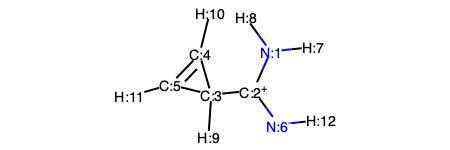

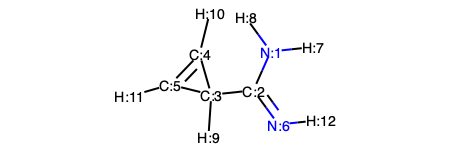

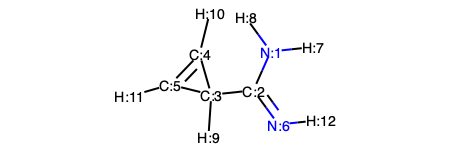

In [19]:
# rxn001363
smiles = df_colin.psmi.values[1363]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed is correct
smiles = '[N:1]([C:2]([C:3]1([H:9])[C:4]([H:10])=[C:5]1[H:11])=[N:6][H:12])([H:7])[H:8]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

# cleaned. 
smiles = '[N:1]([C:2]([C:3]1([H:9])[C:4]([H:10])=[C:5]1[H:11])=[N:6][H:12])([H:7])[H:8]'
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol3)

[C:1]([C+:2]([O-:3])[N:6]([C:4](=[C:5]([H:11])[H:12])[H:10])[H:13])([H:7])([H:8])[H:9]


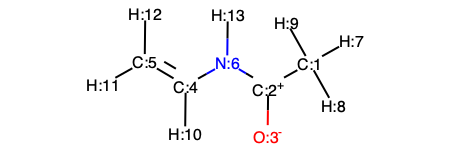

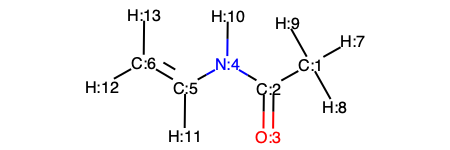

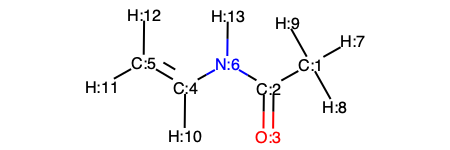

In [23]:
# rxn002841
smiles = df_colin.psmi.values[2841]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed. wrong atom map!
smiles = '[C:1]([C:2](=[O:3])[N:4]([C:5](=[C:6]([H:12])[H:13])[H:11])[H:10])([H:7])([H:8])[H:9]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

# cleaned. 
smiles = '[C:1]([C:2](=[O:3])[N:6]([C:4](=[C:5]([H:11])[H:12])[H:10])[H:13])([H:7])([H:8])[H:9]'
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol3)

[O-:1][C+:2]([N:3]([C:4](=[C:5]([C:6]([H:11])([H:12])[H:13])[H:10])[H:9])[H:8])[H:7]


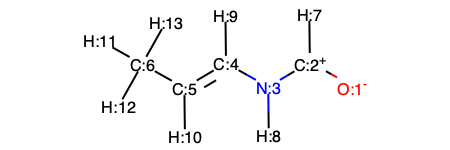

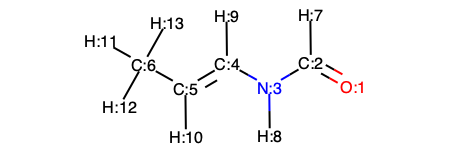

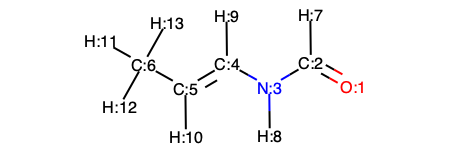

In [27]:
# rxn002999
smiles = df_colin.psmi.values[2999]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed. correct atom map!
smiles = '[O:1]=[C:2]([N:3]([C:4](=[C:5]([C:6]([H:11])([H:12])[H:13])[H:10])[H:9])[H:8])[H:7]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

# cleaned. 
smiles = '[O:1]=[C:2]([N:3]([C:4](=[C:5]([C:6]([H:11])([H:12])[H:13])[H:10])[H:9])[H:8])[H:7]'
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol3)

[C:1]([C:2](=[C:3]([H:10])[H:11])[N:4]([C+:5]([O-:6])[H:13])[H:12])([H:7])([H:8])[H:9]


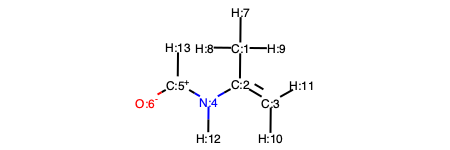

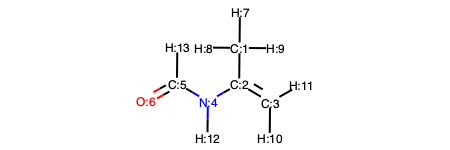

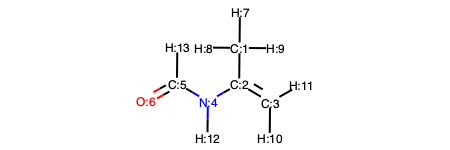

In [31]:
# rxn004318
smiles = df_colin.psmi.values[4318]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed. correct atom map!
smiles = '[C:1]([C:2](=[C:3]([H:10])[H:11])[N:4]([C:5](=[O:6])[H:13])[H:12])([H:7])([H:8])[H:9]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

# cleaned. 
smiles = '[C:1]([C:2](=[C:3]([H:10])[H:11])[N:4]([C:5](=[O:6])[H:13])[H:12])([H:7])([H:8])[H:9]'
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol3)

[C:1]([O:4][C+:3]([N-:2][H:9])[N:5]([H:10])[H:11])([H:6])([H:7])[H:8]


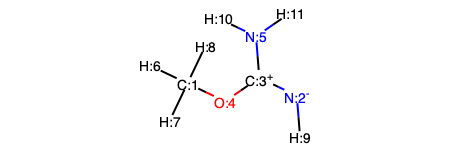

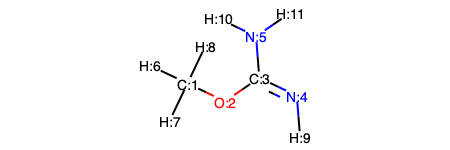

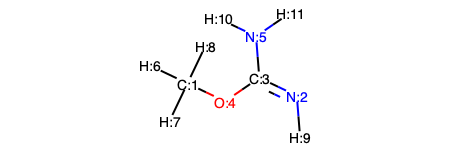

In [33]:
# rxn004405
smiles = df_colin.psmi.values[4405]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed. incorrect atom map!
smiles = '[C:1]([O:2][C:3](=[N:4][H:9])[N:5]([H:10])[H:11])([H:6])([H:7])[H:8]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

# cleaned. 
smiles = '[C:1]([O:4][C:3](=[N:2][H:9])[N:5]([H:10])[H:11])([H:6])([H:7])[H:8]'
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol3)

[N:1]([C+:2]([C-:3]([N+:4]#[N:5])[H:9])[N-:6][H:10])([H:7])[H:8]


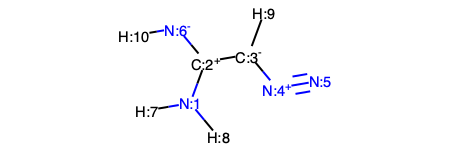

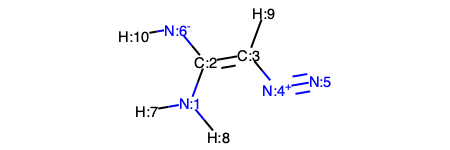

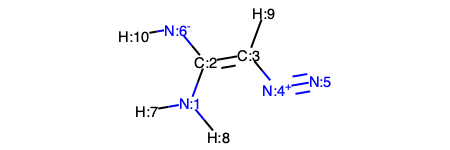

In [36]:
# rxn006063
smiles = df_colin.psmi.values[6063]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed. correct atom map!
smiles = '[N:1]([C:2](=[C:3]([N+:4]#[N:5])[H:9])[N-:6][H:10])([H:7])[H:8]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

# cleaned. 
smiles = '[N:1]([C:2](=[C:3]([N+:4]#[N:5])[H:9])[N-:6][H:10])([H:7])[H:8]'
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol3)

[N:1]([C+:2]([C:3]([C:4]#[N:5])([H:9])[H:10])[N-:6][H:11])([H:7])[H:8]


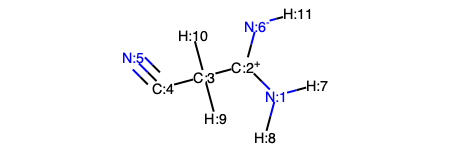

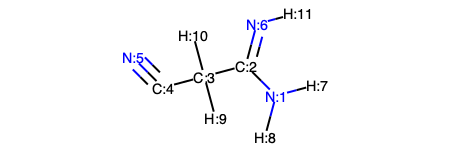

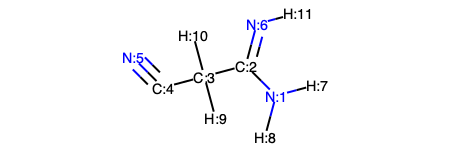

In [40]:
# rxn007052
smiles = df_colin.psmi.values[7052]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed. correct atom map!
smiles = '[N:1]([C:2]([C:3]([C:4]#[N:5])([H:9])[H:10])=[N:6][H:11])([H:7])[H:8]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

# cleaned. 
smiles = '[N:1]([C:2]([C:3]([C:4]#[N:5])([H:9])[H:10])=[N:6][H:11])([H:7])[H:8]'
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol3)

[O-:1][C+:2]([N:5]([C:3](=[C:4]([H:8])[H:9])[H:7])[H:10])[H:6]


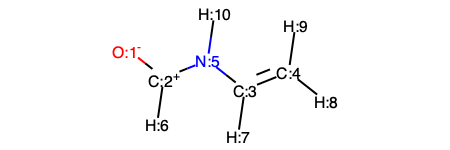

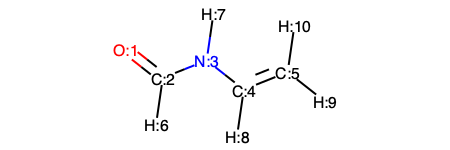

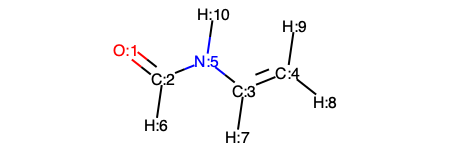

In [42]:
# rxn007197
smiles = df_colin.psmi.values[7197]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed. incorrect atom map!
smiles = '[O:1]=[C:2]([N:3]([C:4](=[C:5]([H:9])[H:10])[H:8])[H:7])[H:6]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

# cleaned. 
smiles = '[O:1]=[C:2]([N:5]([C:3](=[C:4]([H:8])[H:9])[H:7])[H:10])[H:6]'
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol3)

[C:1]([C:2](=[C:4]([N:3]([C+:5]([O-:6])[H:13])[H:11])[H:12])[H:10])([H:7])([H:8])[H:9]


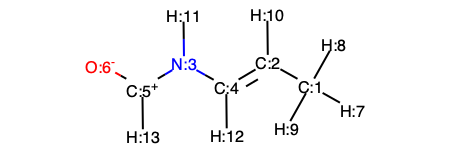

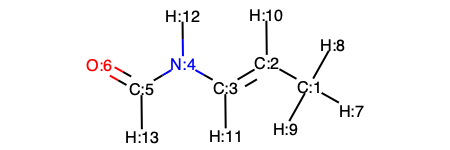

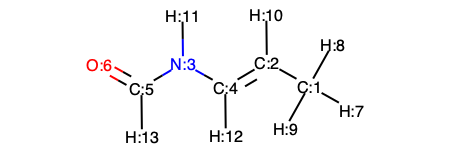

In [45]:
# rxn007994
smiles = df_colin.psmi.values[7994]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed. incorrect atom map!
smiles = '[C:1]([C:2](=[C:3]([N:4]([C:5](=[O:6])[H:13])[H:12])[H:11])[H:10])([H:7])([H:8])[H:9]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

# cleaned. 
smiles = '[C:1]([C:2](=[C:4]([N:3]([C:5](=[O:6])[H:13])[H:11])[H:12])[H:10])([H:7])([H:8])[H:9]'
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol3)

[O-:1][C+:2]([N-:3][H:8])/[N:7]=[C:6](\[C+:5]=[N:4][H:9])[H:10]


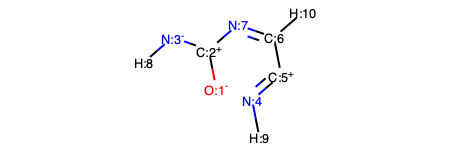

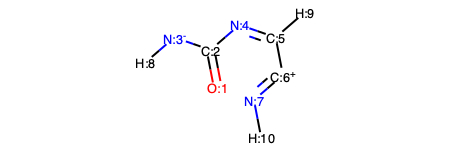

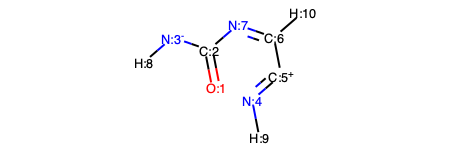

In [49]:
# rxn008608
smiles = df_colin.psmi.values[8608]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed. incorrect atom map!
smiles = '[O:1]=[C:2]([N-:3][H:8])/[N:4]=[C:5](\[C+:6]=[N:7][H:10])[H:9]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

# cleaned. 
smiles = '[O:1]=[C:2]([N-:3][H:8])/[N:7]=[C:6](\[C+:5]=[N:4][H:9])[H:10]'
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol3)

[N+:1]1([H:8])([H:9])[C:2](=[C:7]([C+:5]([N-:4][H:11])[O:6][H:12])[H:13])[C-:3]1[H:10]


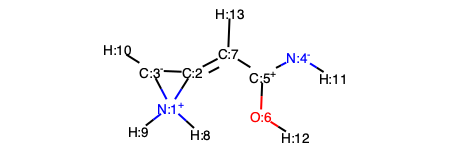

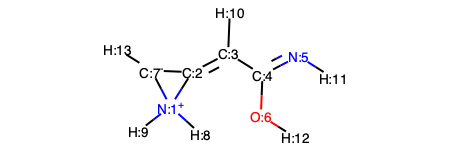

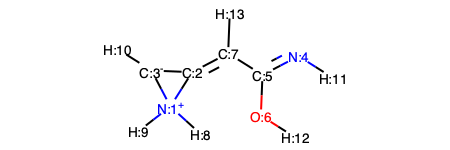

In [52]:
# rxn009036
smiles = df_colin.psmi.values[9036]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed. incorrect atom map!
smiles = '[N+:1]1([H:8])([H:9])[C:2](=[C:3]([C:4](=[N:5][H:11])[O:6][H:12])[H:10])[C-:7]1[H:13]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

# cleaned. 
smiles = '[N+:1]1([H:8])([H:9])[C:2](=[C:7]([C:5](=[N:4][H:11])[O:6][H:12])[H:13])[C-:3]1[H:10]'
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol3)

[C:1](=[C:2]([C:3](=[C:4]([N:5]([C+:6]([O-:7])[H:11])[H:14])[H:13])[H:12])[H:8])([H:9])[H:10]


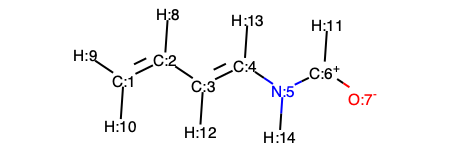

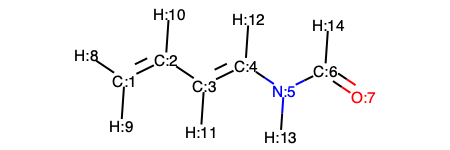

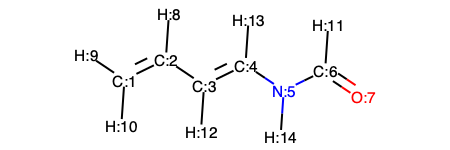

In [55]:
# rxn009291
smiles = df_colin.psmi.values[9291]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed. incorrect atom map!
smiles = '[C:1](=[C:2]([C:3](=[C:4]([N:5]([C:6](=[O:7])[H:14])[H:13])[H:12])[H:11])[H:10])([H:8])[H:9]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

# cleaned. 
smiles = '[C:1](=[C:2]([C:3](=[C:4]([N:5]([C:6](=[O:7])[H:11])[H:14])[H:13])[H:12])[H:8])([H:9])[H:10]'
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol3)

[O-:1][C+:2]([C:3]#[C:4][H:8])[N:7]([C:5](=[C:6]([H:10])[H:11])[H:9])[H:12]


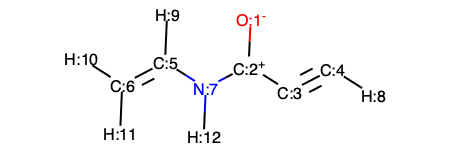

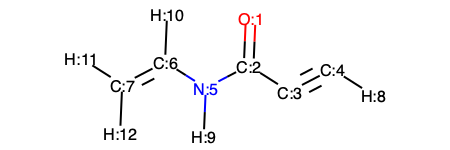

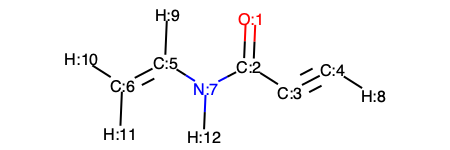

In [58]:
# rxn009986
smiles = df_colin.psmi.values[9986]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed. incorrect atom map!
smiles = '[O:1]=[C:2]([C:3]#[C:4][H:8])[N:5]([C:6](=[C:7]([H:11])[H:12])[H:10])[H:9]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

# cleaned. 
smiles = '[O:1]=[C:2]([C:3]#[C:4][H:8])[N:7]([C:5](=[C:6]([H:10])[H:11])[H:9])[H:12]'
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol3)

[O:1]([C+:2]1[C:3]([H:9])=[N:4][C+:6]([N-:5][H:10])[N-:7]1)[H:8]


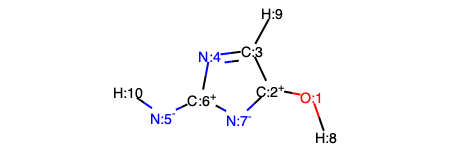

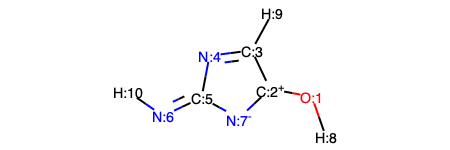

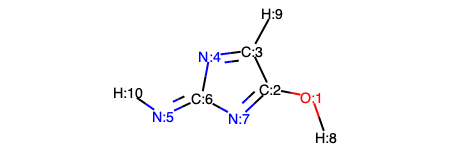

In [66]:
# rxn010599
smiles = df_colin.psmi.values[10599]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed. incorrect atom map!
smiles = '[O:1]([C+:2]1[C:3]([H:9])=[N:4][C:5](=[N:6][H:10])[N-:7]1)[H:8]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

# cleaned. with better resonance
smiles = '[O:1]([C:2]1[C:3]([H:9])=[N:4][C:6](=[N:5][H:10])[N:7]=1)[H:8]'
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol3)

[N-:1]([C+:2]([O-:3])[C+:5]1[C:4]([H:9])([H:10])[C:6]([H:11])([H:12])[N:7]1[H:13])[H:8]


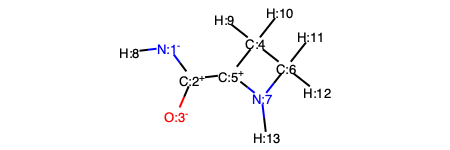

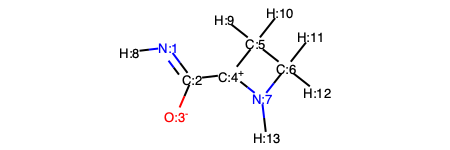

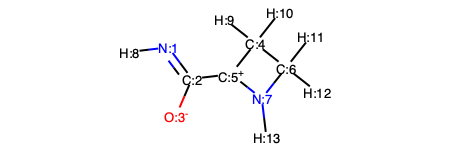

In [69]:
# rxn010667
smiles = df_colin.psmi.values[10667]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed. incorrect atom map!
smiles = '[N:1](=[C:2]([O-:3])[C+:4]1[C:5]([H:9])([H:10])[C:6]([H:11])([H:12])[N:7]1[H:13])[H:8]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

# cleaned. with better resonance
smiles = '[N:1](=[C:2]([O-:3])[C+:5]1[C:4]([H:9])([H:10])[C:6]([H:11])([H:12])[N:7]1[H:13])[H:8]'
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol3)

[C:1]([N:2]([C+:3]([O:4][H:12])[N-:5][C+:6]([N-:7][H:14])[H:13])[H:11])([H:8])([H:9])[H:10]


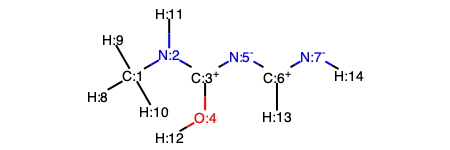

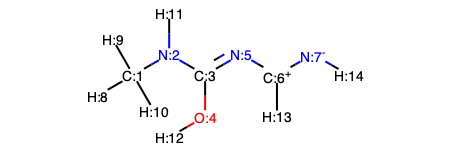

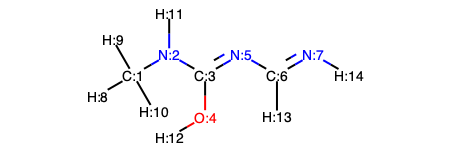

In [74]:
# rxn012125
smiles = df_colin.psmi.values[12125]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed. correct atom map! but not best resonance
smiles = '[C:1]([N:2]([C:3]([O:4][H:12])=[N:5][C+:6]([N-:7][H:14])[H:13])[H:11])([H:8])([H:9])[H:10]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

# cleaned. with better resonance
smiles = '[C:1]([N:2]([C:3]([O:4][H:12])=[N:5][C:6](=[N:7][H:14])[H:13])[H:11])([H:8])([H:9])[H:10]'
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol3)

[O:1]([C:2]([C:3](=[C:4]([H:11])[H:12])[N:5]([C+:6]([O-:7])[H:14])[H:13])([H:9])[H:10])[H:8]


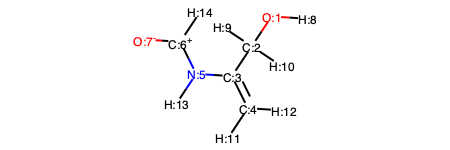

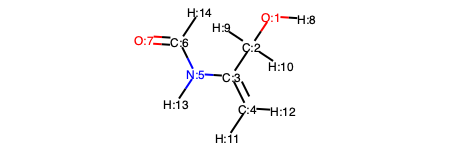

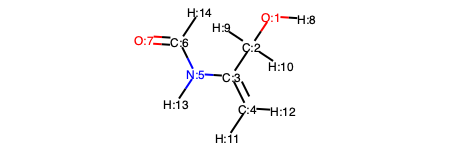

In [77]:
# rxn013562
smiles = df_colin.psmi.values[13562]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed. correct atom map!
smiles = '[O:1]([C:2]([C:3](=[C:4]([H:11])[H:12])[N:5]([C:6](=[O:7])[H:14])[H:13])([H:9])[H:10])[H:8]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

# cleaned. with better resonance
smiles = '[O:1]([C:2]([C:3](=[C:4]([H:11])[H:12])[N:5]([C:6](=[O:7])[H:14])[H:13])([H:9])[H:10])[H:8]'
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol3)

[N:1]([C+:5]([N-:4][N:3]=[C:2]=[O:7])[N:6]([H:10])[H:11])([H:8])[H:9]


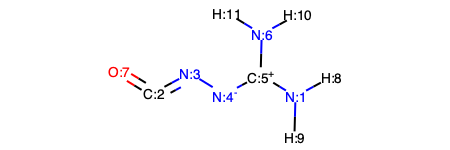

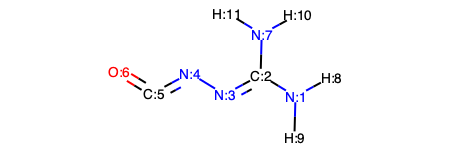

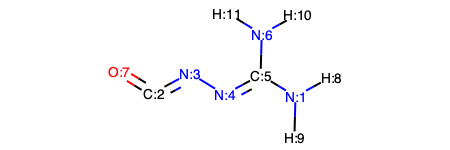

In [81]:
# rxn013739
smiles = df_colin.psmi.values[13739]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed. incorrect atom map!
smiles = '[N:1]([C:2](=[N:3][N:4]=[C:5]=[O:6])[N:7]([H:10])[H:11])([H:8])[H:9]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

# cleaned. 
smiles = '[N:1]([C:5](=[N:4][N:3]=[C:2]=[O:7])[N:6]([H:10])[H:11])([H:8])[H:9]'
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol3)

[O-:1][C+:2]([N:3]([C:4](=[C:5]([H:10])[H:11])[H:9])[H:8])[N:7]=[C:6]([H:12])[H:13]


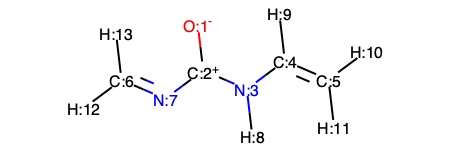

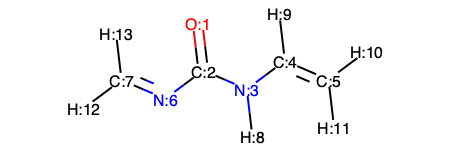

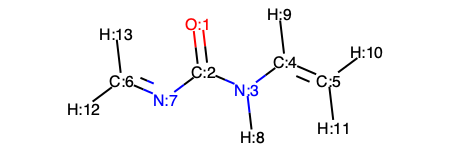

In [84]:
# rxn013792
smiles = df_colin.psmi.values[13792]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed. incorrect atom map!
smiles = '[O:1]=[C:2]([N:3]([C:4](=[C:5]([H:10])[H:11])[H:9])[H:8])[N:6]=[C:7]([H:12])[H:13]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

# cleaned. 
smiles = '[O:1]=[C:2]([N:3]([C:4](=[C:5]([H:10])[H:11])[H:9])[H:8])[N:7]=[C:6]([H:12])[H:13]'
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol3)

[N-:1]([C+:2]([O-:5])[C:7](=[C:6]([N+:4]#[N:3])[H:9])[H:10])[H:8]


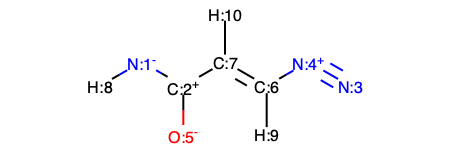

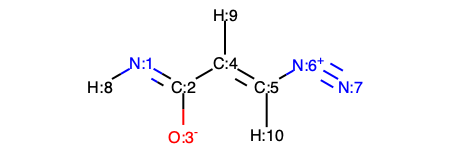

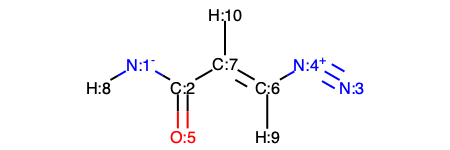

In [87]:
# rxn014026
smiles = df_colin.psmi.values[14026]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed. incorrect atom map!
smiles = '[N:1](=[C:2]([O-:3])[C:4](=[C:5]([N+:6]#[N:7])[H:10])[H:9])[H:8]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

# cleaned.
smiles = '[N-:1]([C:2](=[O:5])[C:7](=[C:6]([N+:4]#[N:3])[H:9])[H:10])[H:8]'
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol3)

[C:1]([C:2]1=[C:3]([H:11])[C@:7]1([C+:5]([N-:4][H:12])[N:6]([H:13])[H:14])[H:15])([H:8])([H:9])[H:10]


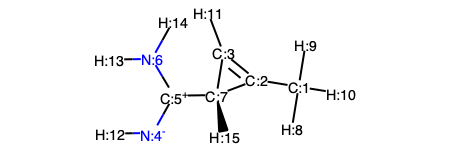

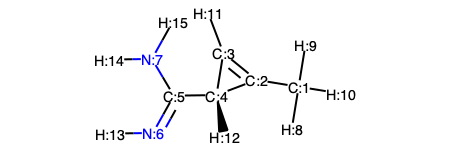

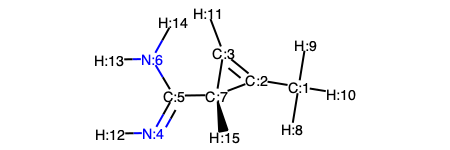

In [91]:
# rxn014292
smiles = df_colin.psmi.values[14292]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed. incorrect atom map!
smiles = '[C:1]([C:2]1=[C:3]([H:11])[C@:4]1([C:5](=[N:6][H:13])[N:7]([H:14])[H:15])[H:12])([H:8])([H:9])[H:10]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

# cleaned.
smiles = '[C:1]([C:2]1=[C:3]([H:11])[C@:7]1([C:5](=[N:4][H:12])[N:6]([H:13])[H:14])[H:15])([H:8])([H:9])[H:10]'
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol3)

[N-:1]([C+:2]([C:3](=[C:4]([C+:5]=[N:6][H:11])[H:10])[H:9])[O-:7])[H:8]


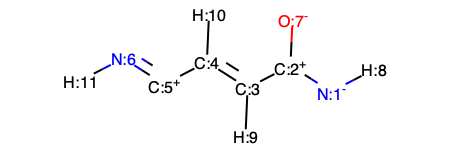

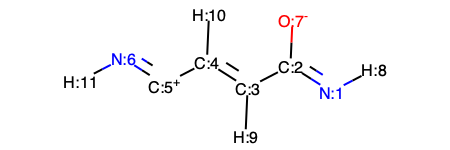

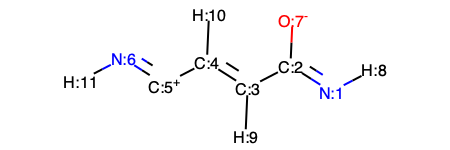

In [94]:
# rxn015444
smiles = df_colin.psmi.values[15444]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed. correct atom map!
smiles = '[N:1](=[C:2]([C:3](=[C:4]([C+:5]=[N:6][H:11])[H:10])[H:9])[O-:7])[H:8]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

# cleaned.
smiles = '[N:1](=[C:2]([C:3](=[C:4]([C+:5]=[N:6][H:11])[H:10])[H:9])[O-:7])[H:8]'
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol3)

[N:1]([C+:2]([N-:3][O:4][H:10])[N:7]=[C:5]=[O:6])([H:8])[H:9]


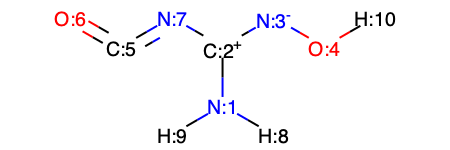

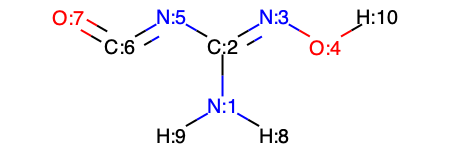

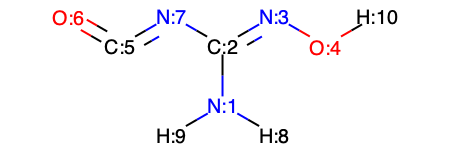

In [96]:
# rxn015544
smiles = df_colin.psmi.values[15544]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed. incorrect atom map!
smiles = '[N:1]([C:2](=[N:3][O:4][H:10])[N:5]=[C:6]=[O:7])([H:8])[H:9]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

# cleaned.
smiles = '[N:1]([C:2](=[N:3][O:4][H:10])[N:7]=[C:5]=[O:6])([H:8])[H:9]'
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol3)

[N:1]([C+:2]([N:3]1[O:4][C:5]1=[O:6])[N-:7][H:10])([H:8])[H:9]


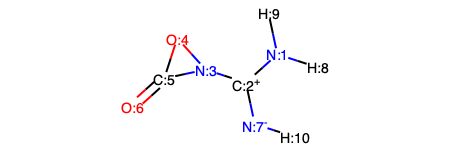

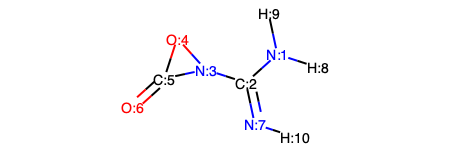

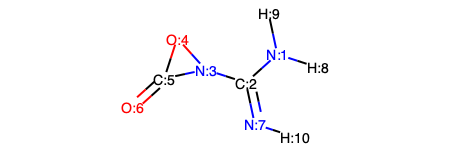

In [99]:
# rxn015545
smiles = df_colin.psmi.values[15545]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed. correct atom map!
smiles = '[N:1]([C:2]([N:3]1[O:4][C:5]1=[O:6])=[N:7][H:10])([H:8])[H:9]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

# cleaned.
smiles = '[N:1]([C:2]([N:3]1[O:4][C:5]1=[O:6])=[N:7][H:10])([H:8])[H:9]'
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol3)

[N-:1]([C+:2]1[N-:3][N+:4]([H:8])([H:10])[C+:5]([O:6][H:11])[N-:7]1)[H:9]


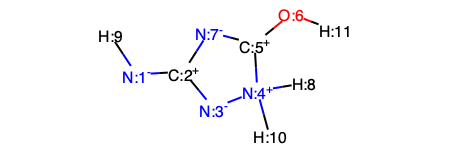

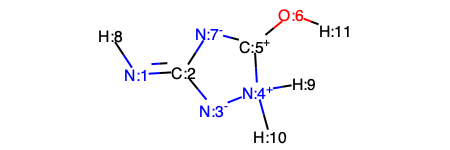

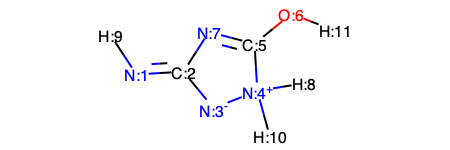

In [104]:
# rxn015622
smiles = df_colin.psmi.values[15622]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed. incorrect atom map!
smiles = '[N:1](=[C:2]1[N-:3][N+:4]([H:9])([H:10])[C+:5]([O:6][H:11])[N-:7]1)[H:8]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

# cleaned. better resonance
smiles = '[N:1](=[C:2]1[N-:3][N+:4]([H:8])([H:10])[C:5]([O:6][H:11])=[N:7]1)[H:9]'
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol3)

[N:1]([C:3](=[C:2]=[N:7][C+:5]([N-:4][H:11])[O:6][H:12])[H:10])([H:8])[H:9]


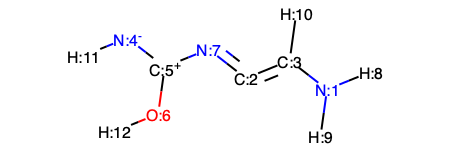

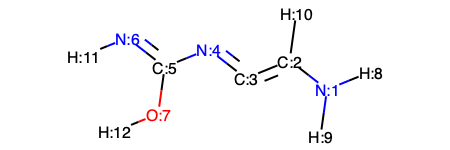

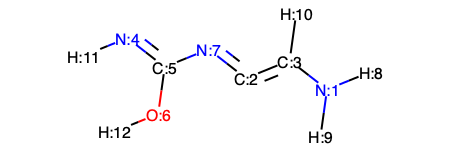

In [108]:
# rxn016330
smiles = df_colin.psmi.values[16330]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed. incorrect atom map!
smiles = '[N:1]([C:2](=[C:3]=[N:4][C:5](=[N:6][H:11])[O:7][H:12])[H:10])([H:8])[H:9]'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

# cleaned.
smiles = '[N:1]([C:3](=[C:2]=[N:7][C:5](=[N:4][H:11])[O:6][H:12])[H:10])([H:8])[H:9]'
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol3)

[N+:1]1([H:8])([H:9])[C+:2]([C-:3]([N+:4](=[C-:5][O:6][H:12])[H:11])[H:10])[N-:7]1


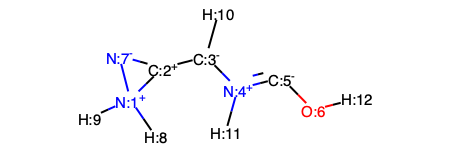

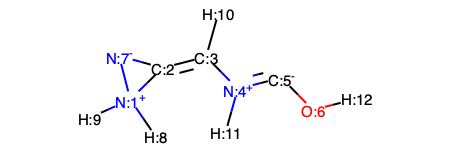

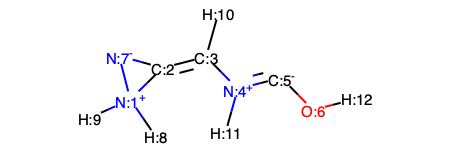

In [112]:
# rxn016347
smiles = df_colin.psmi.values[16347]
print(smiles)
mol1 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol1)

# proposed. correct atom map!
smiles = '[N+:1]1([H:8])([H:9])[C:2](=[C:3]([N+:4](=[C-:5][O:6][H:12])[H:11])[H:10])[N-:7]1'
mol2 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol2)

# cleaned.
smiles = '[N+:1]1([H:8])([H:9])[C:2](=[C:3]([N+:4](=[C-:5][O:6][H:12])[H:11])[H:10])[N-:7]1'
mol3 = Chem.MolFromSmiles(smiles, sanitize=False)
display(mol3)